In [14]:
from __future__ import print_function
from collections import defaultdict
from dateutil import parser
from glob import glob
import logging
import matplotlib.path as mplpath
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas_gbq.gbq import GenericGBQException
import skimage
import skimage.io as skio
from skimage import draw
import subprocess
import time
import ujson as json

from optical_vessel_detection.core.annotation_utils import get_labeled_props
from optical_vessel_detection.core import img_utils as iutils
from optical_vessel_detection.core import planet_utils as putils

from optical_vessel_detection.support import detection_metrics
from optical_vessel_detection.support import notebook_utils
from optical_vessel_detection.support import regions
from optical_vessel_detection.support import info

%matplotlib inline

proj_id = os.environ['PROJ_ID']

## Process/Load Info

These instructions are specific to GFW's setup. You will need to adapt this
your specific situation. 

* `mkdir data/paper/scene_info`

Then:

In [15]:
scene_map = notebook_utils.create_scene_map(
    f'{proj_id}.machine_learning_production.planet_scene_info')

detections_map = notebook_utils.create_detections_map(
    f'{proj_id}.machine_learning_production.detected_pair_trawlers_1_1_aug')

paths = (
    glob("../../../../image-vessel-identification/data/paper/random_annotations/*.tif") 
  + glob("../../../../image-vessel-identificationdata/paper/random_annotations/*.png")
)

annotations_map = notebook_utils.create_annotations_map(paths, 
                                          'gs://machine-learning-production/planet_images/nk_detection/',
                                          f'{proj_id}:machine_learning_dev_ttl_120d.random_annotations_20')
annotations_df = pd.concat(annotations_map.values())

Downloading: 100%|██████████| 83171/83171 [00:10<00:00, 7791.86rows/s]
INFO:pandas_gbq.gbq:Total time taken 12.86 s.
Finished at 2020-07-22 07:33:33.
Downloading: 100%|██████████| 128/128 [00:00<00:00, 349.39rows/s]


20180514
20180522
20180715
20180814
20180826
20180911
20180917
20180929
20181008
Skipping 20181008_013524_1010
20181102


## Process Detections

In [16]:
# XXX
import imp
imp.reload(iutils)
imp.reload(detection_metrics)

class Detection(detection_metrics.Detection):
    annotations = annotations_map
    detections = detections_map
    scenes = scene_map
    annotation_path_templates = [
        '../../../../image-vessel-identification/data/paper/random_annotations/{}_3B_Visual.*']
    
print(Detection.metrics_for_scene_ids(['20180715_012124_0f36']))

{'precision': 0.0, 'recall': 0.0, 'n_predicted': 0, 'n_annotated': 0, 'n_true_positives': 0, 'n_false_positives': 0, 'n_fp_single_trawler': 0, 'n_fp_other_boat': 0, 'n_scenes': 1, 'area_km2': 178.01281735380508}


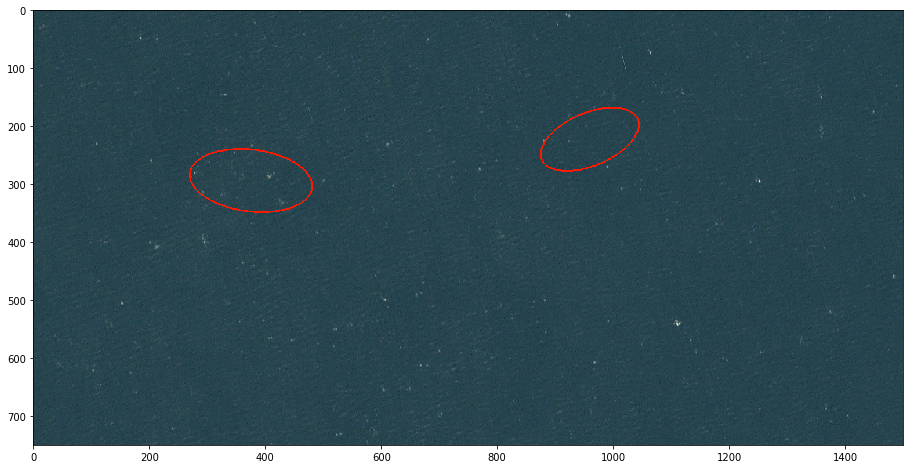

In [17]:
# Example of detection failure due to whitecaps
img = Detection.overlay_detections_for_path(
    '../../../../image-vessel-identification/data/paper/random_annotations/20181102_010650_0f49_3B_Visual.tif')
plt.figure(figsize=(16, 8))
plt.imshow(img[1750:2500, 1000:2500])
plt.show()

In [18]:
logger = logging.getLogger().setLevel(logging.INFO)

In [19]:
random_paths = (glob("../../../../image-vessel-identification/data/paper/random_annotations/*.tif") +
                glob("../../../../image-vessel-identification/data/paper/random_annotations/*.png"))
scene_ids = sorted(set([os.path.basename(x).rsplit('_', 2)[0] 
                        for x in random_paths]))

In [20]:
def no_pair_trawlers(scene_id):
    amap = annotations_map[scene_id.split('_')[0]]
    df = amap[amap.scene_id == scene_id]
    return (((df.kind == 'pair_trawlers').sum() == 0) and
             (df.kind == 'single_trawler').sum() == 0)

In [21]:
with open('../../../../image-vessel-identification/data/paper/misc_data/random_annotations_block_1.txt') as f:
    lines = f.read().strip().split('\n')
    state_map = {os.path.basename(x.split('--')[0].strip()).rsplit('_', 2)[0] : 
                         x.split(':')[-1].strip() for x in lines}

state_metrics = {}
total_scenes = 0
for state in sorted(set(state_map.values())):
    state_scene_ids = [x for x in scene_ids if state_map.get(x, "NA") == state]
    scenes_wout_pairs = [x for x in state_scene_ids if no_pair_trawlers(x)]
    total_scenes += len(scenes_wout_pairs)
    metrics = Detection.metrics_for_scene_ids(scenes_wout_pairs)
    state_metrics[state] = metrics
print(total_scenes)

INFO:root:scene 20180917_011715_0f3b has 1 false positives
INFO:root:scene 20180917_012233_1018 has 1 false positives
INFO:root:scene 20180929_010234_0f4d has 1 false positives
INFO:root:scene 20180929_010806_104e has 2 false positives
INFO:root:scene 20180929_013901_1035 has 2 false positives
INFO:root:scene 20181102_010650_0f49 has 2 false positives
INFO:root:scene 20180911_013603_0f25 has 1 false positives
INFO:root:scene 20181008_011443_0f4b has 1 false positives
INFO:root:scene 20181008_013037_1008 has 2 false positives


98


State: calm
    scenes: 53
    false positives: 7
    false positives / 1000 km2: 0.7
State: wavy
    scenes: 39
    false positives: 4
    false positives / 1000 km2: 0.5
State: choppy
    scenes: 5
    false positives: 2
    false positives / 1000 km2: 2.2
Overall
    scenes: 97
    false_posives: 26
    false_positives / 1000 km2: 1.3


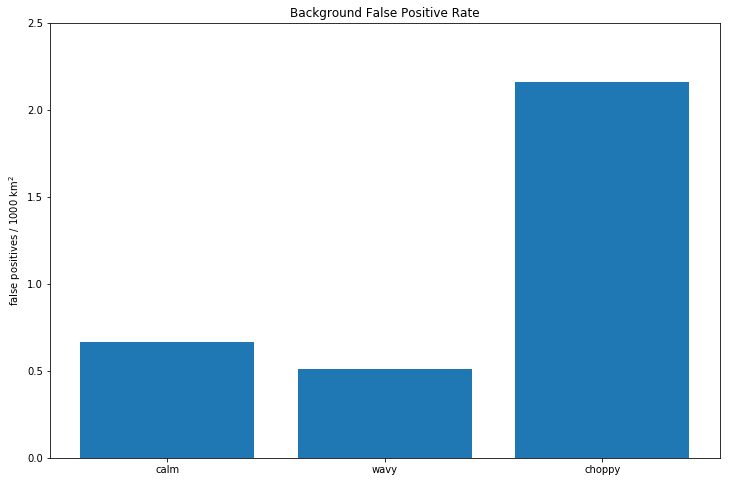

In [22]:
total_scenes = 0
total_fp = 0
total_km2 = 0
total_ob = 0
fp_per_1000km2 = []
other_fp_per_1000km2 = []
for state in ['calm', 'wavy', 'choppy']:
    metrics = state_metrics[state]
    total_fp += metrics['n_false_positives']
    total_scenes += metrics['n_scenes']
    fp_without_boats = (metrics['n_false_positives'] - 
                         metrics['n_fp_other_boat'] -
                         metrics['n_fp_single_trawler'])
    total_fp += metrics['n_false_positives']
    total_ob += metrics['n_fp_other_boat']
    total_km2 += metrics['area_km2']
    fp_per_1000km2.append(fp_without_boats / metrics['area_km2'] * 1000)
    other_fp_per_1000km2.append(metrics['n_fp_other_boat'] / metrics['area_km2'] * 1000)
    print('State:', state)
    print('    scenes:', metrics['n_scenes'])
    print('    false positives:', metrics['n_false_positives'])
    print('    false positives / 1000 km2: {:.1f}'.format(1000 * metrics['n_false_positives'] / metrics['area_km2']))

print("Overall")
print('    scenes:', total_scenes)
print('    false_posives:', total_fp)
print('    false_positives / 1000 km2: {:.1f}'.format(1000 * total_fp / total_km2) )
    
plt.figure(figsize=(12,8))
plt.bar([0, 1, 2], fp_per_1000km2, label='other')
plt.ylabel('false positives / 1000 km$^2$')
plt.xticks([0, 1, 2], ['calm', 'wavy', 'choppy'])
plt.title('Background False Positive Rate')
_ = plt.ylim(0, 2.5)

## The Test Set

We are interested in the background false positive rate -- that is the false
positive rate in scenes without other pair trawlers. This excludes false positives
due to picking the wrong pair in areas of closely packed pair trawlers and
other similar errors. We are trying to find how large an effect is expected
if we include large empty areas in the counted regions For this reason we chose
scenes without large clusters of boats.

### Check that none of the False Positive Test In Training

In [23]:
training_paths = glob('../data/pair_trawl_aug_tiles_768/*.png')
training_scene_ids = set([x.split('__')[-1].rsplit('_', 3)[0] for x in training_paths])
assert not set(scene_ids) & training_scene_ids, "should be no overlap between training and fp scene ids"